# Install Libraries

In [1]:
!pip install dgl

     |████████████████████████████████| 3.0MB 2.7MB/s 


# Imports

In [2]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
from dgl.data import citation_graph as citegrh
import networkx as nx
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import numpy as np

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


# MODEL

In [0]:
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        # Inheriting the class layer
        super(GCNLayer, self).__init__()
        # Declaring the Linear Layer
        self.linear = nn.Linear(in_feats, out_feats)

    def message_func(self,edges):
        #New Edges are the messages functions
        new_edges = None

        #Iterating the edges
        for i_no,row in enumerate(edges.src['h']):
            
            #Source Vertex
            src = edges.edges()[0][i_no]
            #Degree of Source Vertex
            degree_src = degrees[src]
            #Dividing by root of degree
            new_row = row/(degree_src ** (1/2))
            
            #making the tensor
            if i_no == 0:
                new_edges = new_row
            elif i_no == 1:
                new_edges = th.stack((new_edges,new_row),0)
            else:
                #Stacking the tensors one over the other
                new_row = new_row.unsqueeze(1)
                new_row = th.transpose(new_row, 0, 1)
                new_edges = th.cat((new_edges,new_row),dim = 0)
        
        return {'m': new_edges}

    def reduce_func(self,nodes):
        #Get the sum of messages from each neighbor 
        h = th.sum(nodes.mailbox['m'], dim = 1)
        new_h = None
        
        #Enumerate the nodes
        for i_no,node in enumerate(nodes.nodes()):

            #Normalize by square root of degree
            new_row =  h[i_no]/(degrees[node]**(1/2))
            
            if i_no == 0:

                #Initializing for the first node
                new_row = new_row.unsqueeze(1)
                new_row = th.transpose(new_row, 0, 1)
                new_h = new_row
            
            else:

                #Stacking up the tensors
                new_row = new_row.unsqueeze(1)
                new_row = th.transpose(new_row, 0, 1)
                new_h = th.cat((new_h,new_row),dim = 0)
        return {'h': new_h}

    def forward(self, g, feature):
        #Creating a local Scope
        with g.local_scope():
            #Assigning the feature data
            g.ndata['h'] = feature
            #Collecting and passing messages
            g.update_all(self.message_func, self.reduce_func)
            h = g.ndata['h']
            #Passing it through FC layer
            return self.linear(h)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #Declaring FC GCNLayers 
        self.layer1 = GCNLayer(34, 32)
        self.layer2 = GCNLayer(32, 2)

    def forward(self, g, features):
        # Passing through first FC Layer 
        x = self.layer1(g, features)
        #Relu Activation Function
        x = F.relu(x)
        #Second Activation Function
        x = self.layer2(g, x)
        return x

# LOAD GRAPH

In [5]:
#Load Karate Club Graph in Networkx
nx_karate_graph = nx.karate_club_graph()

#Load the networkx object into dgl graph object
dgl_karate_graph = dgl.DGLGraph(nx_karate_graph)

#print the karate gnx_karate_graphraph object  to get basic graph info
print(dgl_karate_graph)

DGLGraph(num_nodes=34, num_edges=156,
         ndata_schemes={}
         edata_schemes={})


#Initialize and Make Features

In [6]:
def make_one_hot_encoded_vector(n = 34):
    """
    Makes a n X n 0's numpy array with diagonals filled with 1's
    """
    arr = np.zeros((n,n))
    for i in range(n):
        arr[i,i] = 1
    print(arr)
    return arr.astype(float)

def make_train_test_masks(n,train_set):
    """
    Making Train and Test Masks
    """
    test_mask = [True] * n
    train_mask = [False] * n
    for index in train_set:
        train_mask[index] = True
        test_mask[index] = False
    return np.array(train_mask),np.array(test_mask)

def make_labels_for_zachary_graph(graph):
    """
    Assign the nodes labels for semi-supervised learning
    """
    #Labels initialize with all zeros
    labels = np.zeros(len(list(graph.nodes())))

    #Community names in the graph
    communities = {"Mr. Hi" : 0,"Officer" : 1}

    #Assigning th labels
    for i in graph.nodes():
        community_name = graph.nodes[i]['club']
        labels[i] = communities[community_name]
    return labels

#Making the one-hot encoded Features
one_hot_encoded_vector = make_one_hot_encoded_vector(n = 34)

#Converting it into Tensor
features = th.from_numpy(one_hot_encoded_vector).float()
print("Features Tensor = ",features)
print("Shape of Features Tensor = ",features.shape)

#Making the labels for the Zachary Graph
#communities = {"Mr. Hi" : 0,"Officer" : 1}
zachary_labels = make_labels_for_zachary_graph(nx_karate_graph)

#Converting it into Tensor
labels = th.from_numpy(zachary_labels).long()
print("Labels Tensor = ",labels)
print("Shape of Labels Tensor = ",labels.shape)

#Make Train mask and Test Mask 
Train_Set_Labels = [0,33]
train_mask_arr,test_mask_arr = make_train_test_masks(34,Train_Set_Labels)

#Converting it into Tensor
train_mask = th.from_numpy(train_mask_arr)
print("train_mask Tensor = ",train_mask)
print("Shape of train_mask Tensor = ",train_mask.shape)

#Converting it into Tensor
test_mask = th.from_numpy(test_mask_arr)
print("test_mask Tensor = ",test_mask)
print("Shape of test_mask Tensor = ",test_mask.shape)


print(features.shape)
print(labels.shape)
print(train_mask.shape)
print(test_mask.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
Features Tensor =  tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
Shape of Features Tensor =  torch.Size([34, 34])
Labels Tensor =  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Shape of Labels Tensor =  torch.Size([34])
train_mask Tensor =  tensor([ True, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True])
Shape of train_mask Tensor =  torch.Size([34])
test

In [0]:
def visualize_features(logits,labels,title):
    """
    Visualize the features
    """
    fig, ax = plt.subplots()
    for i_no in range(logits.shape[0]):
        
        # Features
        x = logits[i_no][0]
        y = logits[i_no][1]
        
        # Scatter based on feature 0 and feature 1
        if labels[i_no] == 0:
            #If label is 0 , then color by RED
            ax.scatter(x,y,c = 'red')
            ax.annotate(i_no,(x,y))
        else:
            #If label is 0 , then color by BLUE
            ax.scatter(x,y,c = 'blue')
            ax.annotate(i_no,(x,y))
    
    ax.set_title('epoch ' + str(title))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()

def evaluate(model, g, features, labels, mask,display = False):
    """
    Get accuracy of th model
    """
    #Evaluate Model
    model.eval()

    with th.no_grad():
        #Get features
        logits = model(g, features)
        #Predicted label
        logits = logits[mask]
        #Actual Lable
        labels = labels[mask]
        _, indices = th.max(logits, dim=1)
        if display != False:
            visualize_features(logits,labels,display)
        correct = th.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)
        

# Training Model

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | Loss 0.6919 | Test Acc 0.5000 | Time(s) nan
Epoch 00001 | Loss 0.6914 | Test Acc 0.5000 | Time(s) nan
Epoch 00002 | Loss 0.6909 | Test Acc 0.5000 | Time(s) nan
Epoch 00003 | Loss 0.6904 | Test Acc 0.5000 | Time(s) 0.0352
Epoch 00004 | Loss 0.6899 | Test Acc 0.5000 | Time(s) 0.0380
Epoch 00005 | Loss 0.6894 | Test Acc 0.5000 | Time(s) 0.0395
Epoch 00006 | Loss 0.6889 | Test Acc 0.5000 | Time(s) 0.0384
Epoch 00007 | Loss 0.6884 | Test Acc 0.5000 | Time(s) 0.0376
Epoch 00008 | Loss 0.6879 | Test Acc 0.5000 | Time(s) 0.0377
Epoch 00009 | Loss 0.6874 | Test Acc 0.5000 | Time(s) 0.0376
Epoch 00010 | Loss 0.6869 | Test Acc 0.5000 | Time(s) 0.0371
Epoch 00011 | Loss 0.6865 | Test Acc 0.5000 | Time(s) 0.0369
Epoch 00012 | Loss 0.6860 | Test Acc 0.5000 | Time(s) 0.0369
Epoch 00013 | Loss 0.6855 | Test Acc 0.5000 | Time(s) 0.0367
Epoch 00014 | Loss 0.6850 | Test Acc 0.5000 | Time(s) 0.0369
Epoch 00015 | Loss 0.6846 | Test Acc 0.5000 | Time(s) 0.0367
Epoch 00016 | Loss 0.6841 | Test 

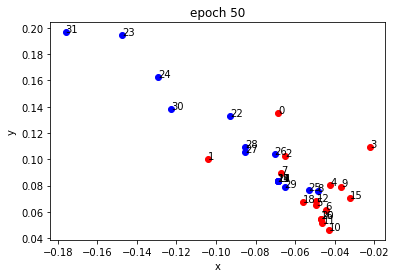

Epoch 00050 | Loss 0.6685 | Test Acc 0.5000 | Time(s) 0.0388
Epoch 00051 | Loss 0.6680 | Test Acc 0.5000 | Time(s) 0.0393
Epoch 00052 | Loss 0.6676 | Test Acc 0.5000 | Time(s) 0.0395
Epoch 00053 | Loss 0.6671 | Test Acc 0.5000 | Time(s) 0.0398
Epoch 00054 | Loss 0.6666 | Test Acc 0.5000 | Time(s) 0.0397
Epoch 00055 | Loss 0.6662 | Test Acc 0.5000 | Time(s) 0.0398
Epoch 00056 | Loss 0.6657 | Test Acc 0.5000 | Time(s) 0.0400
Epoch 00057 | Loss 0.6653 | Test Acc 0.5000 | Time(s) 0.0399
Epoch 00058 | Loss 0.6648 | Test Acc 0.5000 | Time(s) 0.0398
Epoch 00059 | Loss 0.6644 | Test Acc 0.5000 | Time(s) 0.0397
Epoch 00060 | Loss 0.6639 | Test Acc 0.5000 | Time(s) 0.0398
Epoch 00061 | Loss 0.6634 | Test Acc 0.5000 | Time(s) 0.0399
Epoch 00062 | Loss 0.6630 | Test Acc 0.5000 | Time(s) 0.0398
Epoch 00063 | Loss 0.6625 | Test Acc 0.5000 | Time(s) 0.0397
Epoch 00064 | Loss 0.6620 | Test Acc 0.5000 | Time(s) 0.0397
Epoch 00065 | Loss 0.6615 | Test Acc 0.5000 | Time(s) 0.0396
Epoch 00066 | Loss 0.661

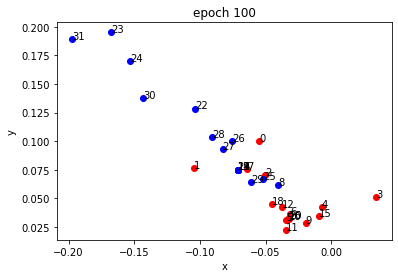

Epoch 00100 | Loss 0.6436 | Test Acc 0.5000 | Time(s) 0.0395
Epoch 00101 | Loss 0.6430 | Test Acc 0.5000 | Time(s) 0.0397
Epoch 00102 | Loss 0.6424 | Test Acc 0.5000 | Time(s) 0.0398
Epoch 00103 | Loss 0.6419 | Test Acc 0.5000 | Time(s) 0.0399
Epoch 00104 | Loss 0.6413 | Test Acc 0.5000 | Time(s) 0.0401
Epoch 00105 | Loss 0.6407 | Test Acc 0.5000 | Time(s) 0.0400
Epoch 00106 | Loss 0.6401 | Test Acc 0.5000 | Time(s) 0.0401
Epoch 00107 | Loss 0.6395 | Test Acc 0.5000 | Time(s) 0.0400
Epoch 00108 | Loss 0.6389 | Test Acc 0.5312 | Time(s) 0.0400
Epoch 00109 | Loss 0.6383 | Test Acc 0.5312 | Time(s) 0.0400
Epoch 00110 | Loss 0.6377 | Test Acc 0.5312 | Time(s) 0.0400
Epoch 00111 | Loss 0.6371 | Test Acc 0.5312 | Time(s) 0.0400
Epoch 00112 | Loss 0.6365 | Test Acc 0.5312 | Time(s) 0.0399
Epoch 00113 | Loss 0.6359 | Test Acc 0.5312 | Time(s) 0.0399
Epoch 00114 | Loss 0.6353 | Test Acc 0.5312 | Time(s) 0.0399
Epoch 00115 | Loss 0.6346 | Test Acc 0.5312 | Time(s) 0.0399
Epoch 00116 | Loss 0.634

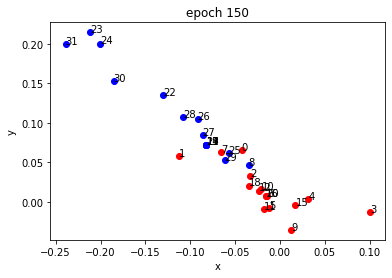

Epoch 00150 | Loss 0.6090 | Test Acc 0.6250 | Time(s) 0.0402
Epoch 00151 | Loss 0.6082 | Test Acc 0.6250 | Time(s) 0.0402
Epoch 00152 | Loss 0.6073 | Test Acc 0.6250 | Time(s) 0.0402
Epoch 00153 | Loss 0.6065 | Test Acc 0.6562 | Time(s) 0.0401
Epoch 00154 | Loss 0.6057 | Test Acc 0.6562 | Time(s) 0.0401
Epoch 00155 | Loss 0.6049 | Test Acc 0.6562 | Time(s) 0.0401
Epoch 00156 | Loss 0.6040 | Test Acc 0.6562 | Time(s) 0.0400
Epoch 00157 | Loss 0.6032 | Test Acc 0.6562 | Time(s) 0.0400
Epoch 00158 | Loss 0.6024 | Test Acc 0.6562 | Time(s) 0.0400
Epoch 00159 | Loss 0.6015 | Test Acc 0.6875 | Time(s) 0.0401
Epoch 00160 | Loss 0.6007 | Test Acc 0.6875 | Time(s) 0.0400
Epoch 00161 | Loss 0.5998 | Test Acc 0.6875 | Time(s) 0.0400
Epoch 00162 | Loss 0.5990 | Test Acc 0.6875 | Time(s) 0.0400
Epoch 00163 | Loss 0.5981 | Test Acc 0.6875 | Time(s) 0.0400
Epoch 00164 | Loss 0.5972 | Test Acc 0.6875 | Time(s) 0.0399
Epoch 00165 | Loss 0.5964 | Test Acc 0.6875 | Time(s) 0.0399
Epoch 00166 | Loss 0.595

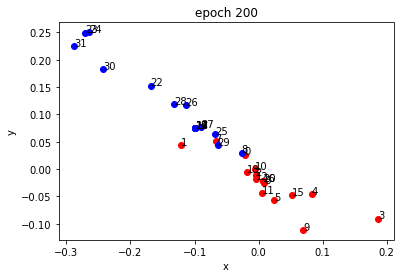

Epoch 00200 | Loss 0.5637 | Test Acc 0.8438 | Time(s) 0.0397
Epoch 00201 | Loss 0.5627 | Test Acc 0.8438 | Time(s) 0.0397
Epoch 00202 | Loss 0.5617 | Test Acc 0.8438 | Time(s) 0.0396
Epoch 00203 | Loss 0.5607 | Test Acc 0.8438 | Time(s) 0.0396
Epoch 00204 | Loss 0.5597 | Test Acc 0.8438 | Time(s) 0.0396
Epoch 00205 | Loss 0.5586 | Test Acc 0.8438 | Time(s) 0.0396
Epoch 00206 | Loss 0.5576 | Test Acc 0.8438 | Time(s) 0.0396
Epoch 00207 | Loss 0.5566 | Test Acc 0.8438 | Time(s) 0.0396
Epoch 00208 | Loss 0.5555 | Test Acc 0.8438 | Time(s) 0.0396
Epoch 00209 | Loss 0.5545 | Test Acc 0.8750 | Time(s) 0.0395
Epoch 00210 | Loss 0.5534 | Test Acc 0.8750 | Time(s) 0.0395
Epoch 00211 | Loss 0.5524 | Test Acc 0.8750 | Time(s) 0.0395
Epoch 00212 | Loss 0.5513 | Test Acc 0.8750 | Time(s) 0.0395
Epoch 00213 | Loss 0.5502 | Test Acc 0.8750 | Time(s) 0.0395
Epoch 00214 | Loss 0.5492 | Test Acc 0.9062 | Time(s) 0.0395
Epoch 00215 | Loss 0.5481 | Test Acc 0.9062 | Time(s) 0.0395
Epoch 00216 | Loss 0.547

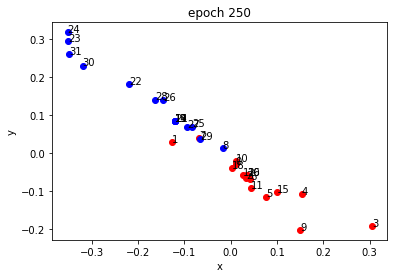

Epoch 00250 | Loss 0.5065 | Test Acc 0.9375 | Time(s) 0.0393
Epoch 00251 | Loss 0.5052 | Test Acc 0.9375 | Time(s) 0.0393
Epoch 00252 | Loss 0.5039 | Test Acc 0.9375 | Time(s) 0.0393
Epoch 00253 | Loss 0.5026 | Test Acc 0.9375 | Time(s) 0.0393
Epoch 00254 | Loss 0.5013 | Test Acc 0.9375 | Time(s) 0.0393
Epoch 00255 | Loss 0.5000 | Test Acc 0.9375 | Time(s) 0.0393
Epoch 00256 | Loss 0.4987 | Test Acc 0.9375 | Time(s) 0.0392
Epoch 00257 | Loss 0.4974 | Test Acc 0.9375 | Time(s) 0.0392
Epoch 00258 | Loss 0.4961 | Test Acc 0.9375 | Time(s) 0.0392
Epoch 00259 | Loss 0.4948 | Test Acc 0.9375 | Time(s) 0.0392
Epoch 00260 | Loss 0.4935 | Test Acc 0.9375 | Time(s) 0.0392
Epoch 00261 | Loss 0.4922 | Test Acc 0.9375 | Time(s) 0.0392
Epoch 00262 | Loss 0.4909 | Test Acc 0.9375 | Time(s) 0.0392
Epoch 00263 | Loss 0.4895 | Test Acc 0.9375 | Time(s) 0.0392
Epoch 00264 | Loss 0.4882 | Test Acc 0.9375 | Time(s) 0.0392
Epoch 00265 | Loss 0.4869 | Test Acc 0.9375 | Time(s) 0.0392
Epoch 00266 | Loss 0.485

In [9]:
#Load Model
net = Net()

#ADAM Optimizer
optimizer = th.optim.Adam(net.parameters(), lr = 2e-4)
dur = []

#Degrees in the karate graph
degrees = dgl_karate_graph.in_degrees(dgl_karate_graph.nodes())

#Number of Epochs
nfepochs = 300

for epoch in range(nfepochs):

    if epoch >=3:
        t0 = time.time()
    
    #Train model ON 
    net.train()
    
    # Get features
    logits = net(dgl_karate_graph, features)

    # Apply Softmax after the result
    logp = F.log_softmax(logits, 1)

    # Negative loss
    loss = F.nll_loss(logp[train_mask], labels[train_mask])

    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >=3:
        dur.append(time.time() - t0)

    # Display the viaulaization of features  or NOT
    disp = False

    # For every fifth epoch draw the visualization
    if epoch % 50 == 0:
        disp = epoch

    #Test Accuracy
    acc = evaluate(net, dgl_karate_graph, features, labels, test_mask,disp)

    print("Epoch {:05d} | Loss {:.4f} | Test Acc {:.4f} | Time(s) {:.4f}".format(epoch, loss.item(), acc, np.mean(dur)))
    